In [1]:
%matplotlib inline
from hmmlearn import hmm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import math
import scipy.stats as stats
import statsmodels.api as sm
import gdown


In [2]:
# Define the ticker and date range
ticker = "TLKM.JK"
start_date = "2014-01-01"
end_date = "2024-11-13"

# Fetch data
data_csv = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Reset index to make the date a regular column, not the index
data_csv = data_csv.reset_index()

# Display the first few rows to confirm
print(data_csv.tail())

# Optionally, save the data to a CSV file
data_csv.to_csv(ticker, index=False)

data = data_csv[data_csv.columns[1:5]]

# Calculate 95% of the total number of rows
num_rows = int(0.95 * len(data))

# Select the first 95% of rows
obs = data.iloc[:num_rows]
# Remove any rows with missing values
obs = obs.dropna()

# Print the monthly data
print(obs)
print(data)

[*********************100%***********************]  1 of 1 completed
           Date    Open    High     Low   Close  Adj Close     Volume
2682 2024-11-06  2780.0  2800.0  2740.0  2740.0     2740.0   66808900
2683 2024-11-07  2760.0  2790.0  2740.0  2760.0     2760.0   79485800
2684 2024-11-08  2760.0  2780.0  2750.0  2750.0     2750.0   66113200
2685 2024-11-11  2720.0  2730.0  2650.0  2690.0     2690.0  108153500
2686 2024-11-12  2660.0  2670.0  2600.0  2600.0     2600.0  215910600
        Open    High     Low   Close
0     2175.0  2200.0  2150.0  2175.0
1     2125.0  2175.0  2100.0  2125.0
2     2175.0  2175.0  2065.0  2085.0
3     2085.0  2085.0  2060.0  2070.0
4     2085.0  2100.0  2065.0  2100.0
...      ...     ...     ...     ...
2547  3230.0  3230.0  3130.0  3150.0
2548  3150.0  3200.0  3130.0  3170.0
2549  3180.0  3190.0  3080.0  3100.0
2550  3100.0  3110.0  3040.0  3040.0
2551  3010.0  3060.0  2990.0  3040.0

[2552 rows x 4 columns]
        Open    High     Low   Close
0    

In [5]:

T = 120
AIC, BIC, HQC, CAIC = [], [], [], []

for n in range(2, 7):
    a, b, c, d = [], [], [], []
    first_time = True

    for i in range(0, T):
        
        if first_time:
            model = hmm.GaussianHMM(n_components=n, init_params="stmc", n_iter=5000)
            first_time = False
        else:
            old_model = model
            model = hmm.GaussianHMM(n_components=n, init_params="", n_iter=5000)
            model.startprob_ = old_model.startprob_
            model.transmat_ = old_model.transmat_
            model.means_ = old_model.means_

            # Normalize startprob_ to ensure it sums to 1
            model.startprob_ = model.startprob_ / np.sum(model.startprob_)

            # Ensure transition matrix rows sum to 1
            model.transmat_ = np.divide(model.transmat_, model.transmat_.sum(axis=1, keepdims=True))

            # If any row sums to 0, reinitialize it to uniform probabilities
            for row in range(n):
                if np.sum(model.transmat_[row]) == 0:
                    model.transmat_[row] = np.full(n, 1 / n)

        # Fit the model using the data
        model.fit(obs[i:i+T])

        log_likelihoods = model.score(obs[i:i+T])
        k = n**2 + 2*n - 1

        aic = -2 * log_likelihoods + 2 * k
        bic = -2 * log_likelihoods + k * np.log(4 * T)
        hqc = -2 * log_likelihoods + k * (np.log(np.log(4 * T)))
        caic = -2 * log_likelihoods + k * (np.log(4 * T) + 1)

        a.append(aic)
        b.append(bic)
        c.append(hqc)
        d.append(caic)

    AIC.append(a)
    BIC.append(b)
    HQC.append(c)
    CAIC.append(d)


Model is not converging.  Current: -2645.3109733638275 is not greater than -2645.310973177563. Delta is -1.862645149230957e-07
Model is not converging.  Current: -2631.0405298305 is not greater than -2631.040529783934. Delta is -4.6566128730773926e-08


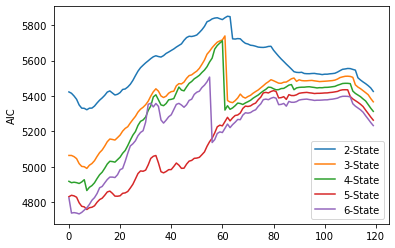

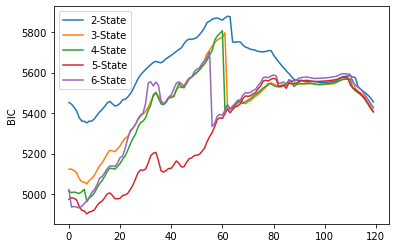

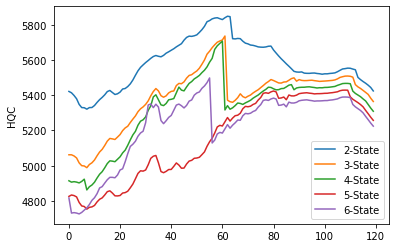

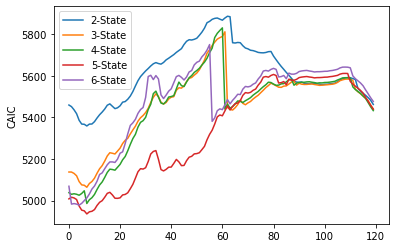

In [6]:

# Plot AIC values for different numbers of components
for i in range(0, 5):
    plt.plot(AIC[i], label=f"{i+2}-State")
plt.ylabel("AIC")
plt.legend()
plt.savefig(f"{ticker}_AIC_plot.png")  # Save the AIC plot with the ticker in the filename
plt.show()

# Plot BIC values for different numbers of components
for i in range(0, 5):
    plt.plot(BIC[i], label=f"{i+2}-State")
plt.ylabel("BIC")
plt.legend()
plt.savefig(f"{ticker}_BIC_plot.png")  # Save the BIC plot with the ticker in the filename
plt.show()

# Plot HQC values for different numbers of components
for i in range(0, 5):
    plt.plot(HQC[i], label=f"{i+2}-State")
plt.ylabel("HQC")
plt.legend()
plt.savefig(f"{ticker}_HQC_plot.png")  # Save the HQC plot with the ticker in the filename
plt.show()

# Plot CAIC values for different numbers of components
for i in range(0, 5):
    plt.plot(CAIC[i], label=f"{i+2}-State")
plt.ylabel("CAIC")
plt.legend()
plt.savefig(f"{ticker}_CAIC_plot.png")  # Save the CAIC plot with the ticker in the filename
plt.show()


In [7]:
#KEPAKE
obs = data.iloc[:num_rows]
first_time = True
n=5
T = 120
w = int(len(obs)*0.85/0.95) - T
likelihood_list = []  

# Creating Likelihood from trained data
for i in range(0, w):
    
    if first_time:
        model = hmm.GaussianHMM(n_components=n, init_params="stmc", n_iter=5000)
        first_time = False
    else:
        old_model = model
        model = hmm.GaussianHMM(n_components=n, init_params="", n_iter=5000)

        # Ensure model parameters match the expected number of components
        model.startprob_ = np.zeros(n)  # Initialize with zeros
        model.transmat_ = np.zeros((n, n))  # Initialize with zeros
        model.means_ = np.zeros((n, old_model.means_.shape[1]))  # Match means dimensions

        # Copy parameters from old model
        if old_model.startprob_.shape[0] == n:
            model.startprob_ = old_model.startprob_
        if old_model.transmat_.shape == (n, n):
            model.transmat_ = old_model.transmat_
        if old_model.means_.shape[0] == n:
            model.means_ = old_model.means_

        # Normalize startprob_ to ensure it sums to 1
        model.startprob_ /= np.sum(model.startprob_)

        # Ensure transition matrix rows sum to 1
        model.transmat_ = np.divide(model.transmat_, model.transmat_.sum(axis=1, keepdims=True))

        # If any row sums to 0, reinitialize it to uniform probabilities
        for row in range(n):
            if row < model.transmat_.shape[0] and np.sum(model.transmat_[row]) == 0:
                model.transmat_[row] = np.full(n, 1 / n)

        # Check for NaNs and reinitialize if necessary
        if np.isnan(model.startprob_).any() or np.isnan(model.transmat_).any():
            print("Invalid parameters detected, reinitializing...")
            model.startprob_ = np.full(n, 1 / n)
            model.transmat_ = np.full((n, n), 1 / n)

    # Fit the model using the data
    model.fit(obs[i:i+T])
    likelihoods = model.score(obs[i:i+T])
    likelihood_list.append(likelihoods)  # Append the likelihood directly


In [8]:
obs = data.iloc[:num_rows]
num_test=int(0.05*len(data))
# Select the first 95% of rows
for i in range (num_test) :
    
    old_model = model
    model = hmm.GaussianHMM(n_components=n, init_params="", n_iter=5000)

    # Ensure model parameters match the expected number of components
    model.startprob_ = np.zeros(n)  # Initialize with zeros
    model.transmat_ = np.zeros((n, n))  # Initialize with zeros
    model.means_ = np.zeros((n, old_model.means_.shape[1]))  # Match means dimensions

        # Copy parameters from old model
    if old_model.startprob_.shape[0] == n:
        model.startprob_ = old_model.startprob_
    if old_model.transmat_.shape == (n, n):
        model.transmat_ = old_model.transmat_
    if old_model.means_.shape[0] == n:
        model.means_ = old_model.means_

        # Normalize startprob_ to ensure it sums to 1
    model.startprob_ /= np.sum(model.startprob_)

        # Ensure transition matrix rows sum to 1
    model.transmat_ = np.divide(model.transmat_, model.transmat_.sum(axis=1, keepdims=True))

        # If any row sums to 0, reinitialize it to uniform probabilities
    for row in range(n):
        if row < model.transmat_.shape[0] and np.sum(model.transmat_[row]) == 0:
            model.transmat_[row] = np.full(n, 1 / n)

        # Check for NaNs and reinitialize if necessary
    if np.isnan(model.startprob_).any() or np.isnan(model.transmat_).any():
        print("Invalid parameters detected, reinitializing...")
        model.startprob_ = np.full(n, 1 / n)
        model.transmat_ = np.full((n, n), 1 / n)

    # Fit the model using the data
    model.fit(obs[w+i:w+i+T])
    curr_likelihood = model.score(obs[w+i:w+i+T])
    # Initialize variables to track the minimum difference and corresponding index
    min_diff = float('inf')  # Start with infinity for the minimum difference
    min_index = -1           # Initialize index for the minimum difference

    # Step 1: Loop through the likelihood_list
    for k, likelihood in enumerate(likelihood_list):
        diff = abs(curr_likelihood - likelihood)  # Calculate the absolute difference
    
        # Step 2: Check if this is the smallest difference
        if diff < min_diff:
            min_diff = diff  # Update the minimum difference
            min_index = k    # Update the index of the closest likelihood

    # Step 3: Get the corresponding likelihood value
    closest_likelihood = likelihood_list[min_index]
    row_values1 = obs.iloc[min_index + T]
    row_values2 = obs.iloc[min_index + T+1]
    
    # Calculate the next day price
    close_price = obs['Close'].iloc[-1] + (( row_values2['Close'] -  row_values1['Close']) * np.sign(curr_likelihood - closest_likelihood))
    open_price = obs['Open'].iloc[-1] + (( row_values2['Open'] - row_values1['Open']) * np.sign(curr_likelihood - closest_likelihood))
    high_price = obs['High'].iloc[-1] + (( row_values2['High'] -  row_values1['High']) * np.sign(curr_likelihood - closest_likelihood))
    low_price = obs['Low'].iloc[-1] + (( row_values2['Low']-  row_values1['Low']) * np.sign(curr_likelihood - closest_likelihood))

    new_row = {'Open': open_price, 'High': high_price, 'Low': low_price, 'Close': close_price}
    new_row_df = pd.DataFrame([new_row])  # Create a DataFrame from the dictionary
    obs = pd.concat([obs, new_row_df], ignore_index=True)
    
    # Step 4: Display the result
    print(f" iteration {i}The closest likelihood value to {curr_likelihood} is {closest_likelihood} at index {min_index}.")


 iteration 0The closest likelihood value to -3222.1888015845893 is -3221.7597700600845 at index 765.
 iteration 1The closest likelihood value to -3216.003819757177 is -3216.057653193672 at index 757.
 iteration 2The closest likelihood value to -3209.238787881708 is -3209.2264846844887 at index 770.
 iteration 3The closest likelihood value to -3204.066224774244 is -3203.7686482710183 at index 878.
 iteration 4The closest likelihood value to -3199.173785273612 is -3199.1358049295563 at index 424.
 iteration 5The closest likelihood value to -3194.66580301529 is -3194.712383310887 at index 1528.
 iteration 6The closest likelihood value to -3189.3020238951835 is -3189.211032258522 at index 1698.
 iteration 7The closest likelihood value to -3182.809204833879 is -3183.187580047434 at index 777.
 iteration 8The closest likelihood value to -3175.2542842388184 is -3175.3303848650135 at index 1961.
 iteration 9The closest likelihood value to -3167.5215687029654 is -3167.5041043915207 at index 403

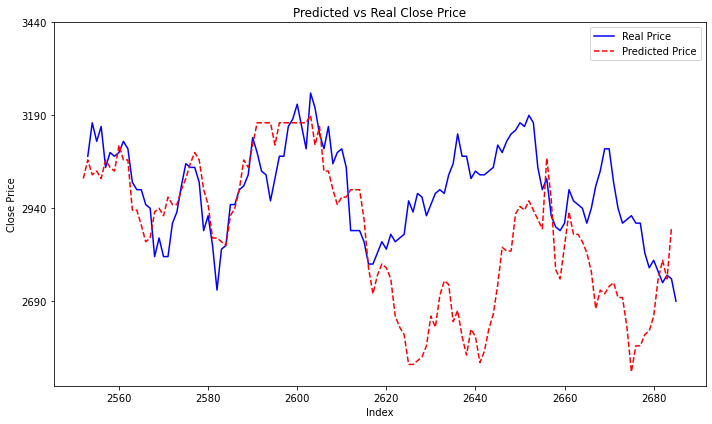

In [9]:
import matplotlib.pyplot as plt

# Assuming num_test is defined
predicted_price = obs["Close"].iloc[-(num_test):-1]
real_price = data["Close"].iloc[-(num_test):-1]

# Plot predicted vs real prices
plt.figure(figsize=(10, 6))

# Plot real prices
plt.plot(real_price.index, real_price, label='Real Price', color='blue')

# Plot predicted prices
plt.plot(predicted_price.index, predicted_price, label='Predicted Price', color='red', linestyle='--')

# Add labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.title('Predicted vs Real Close Price')
plt.legend()

# Set y-axis ticks with a step of 500
plt.yticks(range(int(real_price.min()), int(real_price.max()) + 250, 250))
plt.savefig(f"{ticker}_Prediction.png")  # Save
# Show plot
plt.tight_layout()
plt.show()


In [10]:
mape = (abs((real_price - predicted_price) / real_price)).mean() * 100

print(f"Mean Absolute Percentage Error (MAPE): {mape:.3f}%")

Mean Absolute Percentage Error (MAPE): 5.400%


In [11]:
predicted_price

2552    3020.0
2553    3070.0
2554    3030.0
2555    3040.0
2556    3020.0
         ...  
2680    2650.0
2681    2750.0
2682    2800.0
2683    2750.0
2684    2890.0
Name: Close, Length: 133, dtype: float64

In [12]:
real_price

2553    3080.0
2554    3170.0
2555    3120.0
2556    3160.0
2557    3050.0
         ...  
2681    2770.0
2682    2740.0
2683    2760.0
2684    2750.0
2685    2690.0
Name: Close, Length: 133, dtype: float64

In [13]:
#Out of Sample
obs = data
first_time = True
T = 120
w = int(len(obs)*0.95/0.95) - T
likelihood_list = []  

# Creating Likelihood from trained data
for i in range(0, w):
    
    if first_time:
        model = hmm.GaussianHMM(n_components=n, init_params="stmc", n_iter=5000)
        first_time = False
    else:
        old_model = model
        model = hmm.GaussianHMM(n_components=n, init_params="", n_iter=5000)

        # Ensure model parameters match the expected number of components
        model.startprob_ = np.zeros(n)  # Initialize with zeros
        model.transmat_ = np.zeros((n, n))  # Initialize with zeros
        model.means_ = np.zeros((n, old_model.means_.shape[1]))  # Match means dimensions

        # Copy parameters from old model
        if old_model.startprob_.shape[0] == n:
            model.startprob_ = old_model.startprob_
        if old_model.transmat_.shape == (n, n):
            model.transmat_ = old_model.transmat_
        if old_model.means_.shape[0] == n:
            model.means_ = old_model.means_

        # Normalize startprob_ to ensure it sums to 1
        model.startprob_ /= np.sum(model.startprob_)

        # Ensure transition matrix rows sum to 1
        model.transmat_ = np.divide(model.transmat_, model.transmat_.sum(axis=1, keepdims=True))

        # If any row sums to 0, reinitialize it to uniform probabilities
        for row in range(n):
            if row < model.transmat_.shape[0] and np.sum(model.transmat_[row]) == 0:
                model.transmat_[row] = np.full(n, 1 / n)

        # Check for NaNs and reinitialize if necessary
        if np.isnan(model.startprob_).any() or np.isnan(model.transmat_).any():
            print("Invalid parameters detected, reinitializing...")
            model.startprob_ = np.full(n, 1 / n)
            model.transmat_ = np.full((n, n), 1 / n)

    # Fit the model using the data
    model.fit(obs[i:i+T])
    likelihoods = model.score(obs[i:i+T])
    likelihood_list.append(likelihoods)  # Append the likelihood directly


Model is not converging.  Current: -2674.8991650520097 is not greater than -2674.899164912312. Delta is -1.396979314449709e-07


In [14]:
obs=data
for i in range (num_test) :
    old_model = model
    model = hmm.GaussianHMM(n_components=n, init_params="", n_iter=5000)

    # Ensure model parameters match the expected number of components
    model.startprob_ = np.zeros(n)  # Initialize with zeros
    model.transmat_ = np.zeros((n, n))  # Initialize with zeros
    model.means_ = np.zeros((n, old_model.means_.shape[1]))  # Match means dimensions

        # Copy parameters from old model
    if old_model.startprob_.shape[0] == n:
        model.startprob_ = old_model.startprob_
    if old_model.transmat_.shape == (n, n):
        model.transmat_ = old_model.transmat_
    if old_model.means_.shape[0] == n:
        model.means_ = old_model.means_

        # Normalize startprob_ to ensure it sums to 1
    model.startprob_ /= np.sum(model.startprob_)

        # Ensure transition matrix rows sum to 1
    model.transmat_ = np.divide(model.transmat_, model.transmat_.sum(axis=1, keepdims=True))

        # If any row sums to 0, reinitialize it to uniform probabilities
    for row in range(n):
        if row < model.transmat_.shape[0] and np.sum(model.transmat_[row]) == 0:
            model.transmat_[row] = np.full(n, 1 / n)

        # Check for NaNs and reinitialize if necessary
    if np.isnan(model.startprob_).any() or np.isnan(model.transmat_).any():
        print("Invalid parameters detected, reinitializing...")
        model.startprob_ = np.full(n, 1 / n)
        model.transmat_ = np.full((n, n), 1 / n)

    # Fit the model using the data
    model.fit(obs[w+i:w+i+T])
    curr_likelihood = model.score(obs[w+i:w+i+T])
    # Initialize variables to track the minimum difference and corresponding index
    min_diff = float('inf')  # Start with infinity for the minimum difference
    min_index = -1           # Initialize index for the minimum difference

    # Step 1: Loop through the likelihood_list
    for k, likelihood in enumerate(likelihood_list):
        diff = abs(curr_likelihood - likelihood)  # Calculate the absolute difference
    
        # Step 2: Check if this is the smallest difference
        if diff < min_diff:
            min_diff = diff  # Update the minimum difference
            min_index = k    # Update the index of the closest likelihood

    # Step 3: Get the corresponding likelihood value
    closest_likelihood = likelihood_list[min_index]
    row_values1 = obs.iloc[min_index + T]
    row_values2 = obs.iloc[min_index + T+1]
    
    # Calculate the next day price
    close_price = obs['Close'].iloc[-1] + (( row_values2['Close'] -  row_values1['Close']) * np.sign(curr_likelihood - closest_likelihood))
    open_price = obs['Open'].iloc[-1] + (( row_values2['Open'] - row_values1['Open']) * np.sign(curr_likelihood - closest_likelihood))
    high_price = obs['High'].iloc[-1] + (( row_values2['High'] -  row_values1['High']) * np.sign(curr_likelihood - closest_likelihood))
    low_price = obs['Low'].iloc[-1] + (( row_values2['Low']-  row_values1['Low']) * np.sign(curr_likelihood - closest_likelihood))

    new_row = {'Open': open_price, 'High': high_price, 'Low': low_price, 'Close': close_price}
    new_row_df = pd.DataFrame([new_row])  # Create a DataFrame from the dictionary
    obs = pd.concat([obs, new_row_df], ignore_index=True)
    
    # Step 4: Display the result
    print(f" iteration {i}The closest likelihood value to {curr_likelihood} is {closest_likelihood} at index {min_index}.")


 iteration 0The closest likelihood value to -2876.579464658224 is -2876.5906060998786 at index 1371.
 iteration 1The closest likelihood value to -2884.8608188826843 is -2885.56205236813 at index 687.
 iteration 2The closest likelihood value to -2901.1698668019135 is -2901.070295056493 at index 683.
 iteration 3The closest likelihood value to -2916.0185230231077 is -2916.245558684401 at index 2343.
 iteration 4The closest likelihood value to -2929.142731868573 is -2929.1385091786697 at index 1387.
 iteration 5The closest likelihood value to -2942.1355432429255 is -2942.105853189424 at index 1565.
 iteration 6The closest likelihood value to -2951.5049869616673 is -2951.2950056897043 at index 1392.
 iteration 7The closest likelihood value to -2962.358602774085 is -2962.481667942203 at index 2315.
 iteration 8The closest likelihood value to -2978.981378440434 is -2978.9010070062 at index 2336.
 iteration 9The closest likelihood value to -2994.0911536188282 is -2994.1900474796976 at index 2

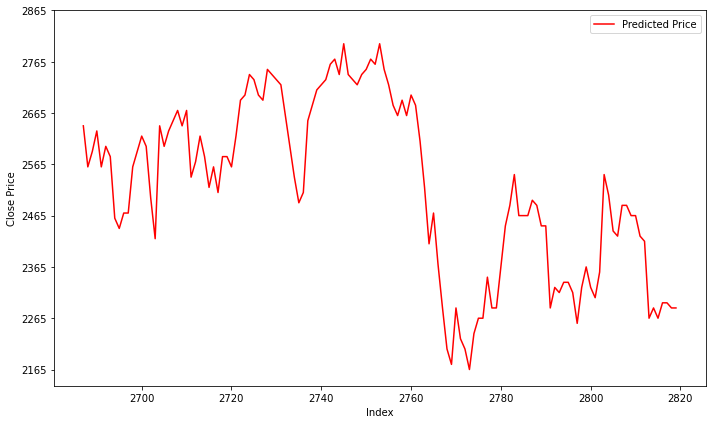

In [15]:
import matplotlib.pyplot as plt

# Assuming num_test is defined
predicted_price = obs["Close"].iloc[-(num_test):-1]


# Plot predicted vs real prices
plt.figure(figsize=(10, 6))

# Plot predicted prices
plt.plot(predicted_price.index, predicted_price, label='Predicted Price', color='red', linestyle='-')

# Add labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()

# Set y-axis ticks with a step of 500
plt.yticks(range(int(predicted_price.min()), int(predicted_price.max()) + 100, 100))
plt.savefig(f"{ticker}_Prediction_Out.png")
# Show plot
plt.tight_layout()
plt.show()
